<center><img src="img/logo_hse.png" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 1: Генеративные сети</center></h2>

# Введение

Не все же нам MNIST генерировать. Давайте посмотрим, как генеративные модели могут использоваться не только для развлечения. Поехали!

Немного вступления и мотивации, для чего мы хотим обучать модель.

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ). 

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

<center><img src="img/magic1.jpg" width="1000"></center>

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

#### Ок, давайте зафиксируем. Какой-то крутой телескоп позволяет открыть новые виды излучения. Идем дальше.

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение. 
#### По фотографиям можно определить тип частицы из космоса: фотон или протон. Знакомая формулировка задачи, не правда ли?

<center><img src="img/shower.jpg" width="500"></center>

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.

<center><img src="img/geo.jpg" width="400"></center>

#### Итак, каждая фотография описывается набором параметров, которые за нас считает телесоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!


<center><img src="img/gamma_p.png" width="600"></center>

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов. 

#### Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from typing import Optional
from typing_extensions import Literal
from IPython.display import clear_output
import random
import os
import torch
from diffusers import DDPMScheduler
from typing import Dict, List, Tuple
from tqdm.auto import tqdm

sns.set_theme()

In [2]:
def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(1975)

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [3]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("data/magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [4]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [5]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [6]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 5, 5 * 3))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

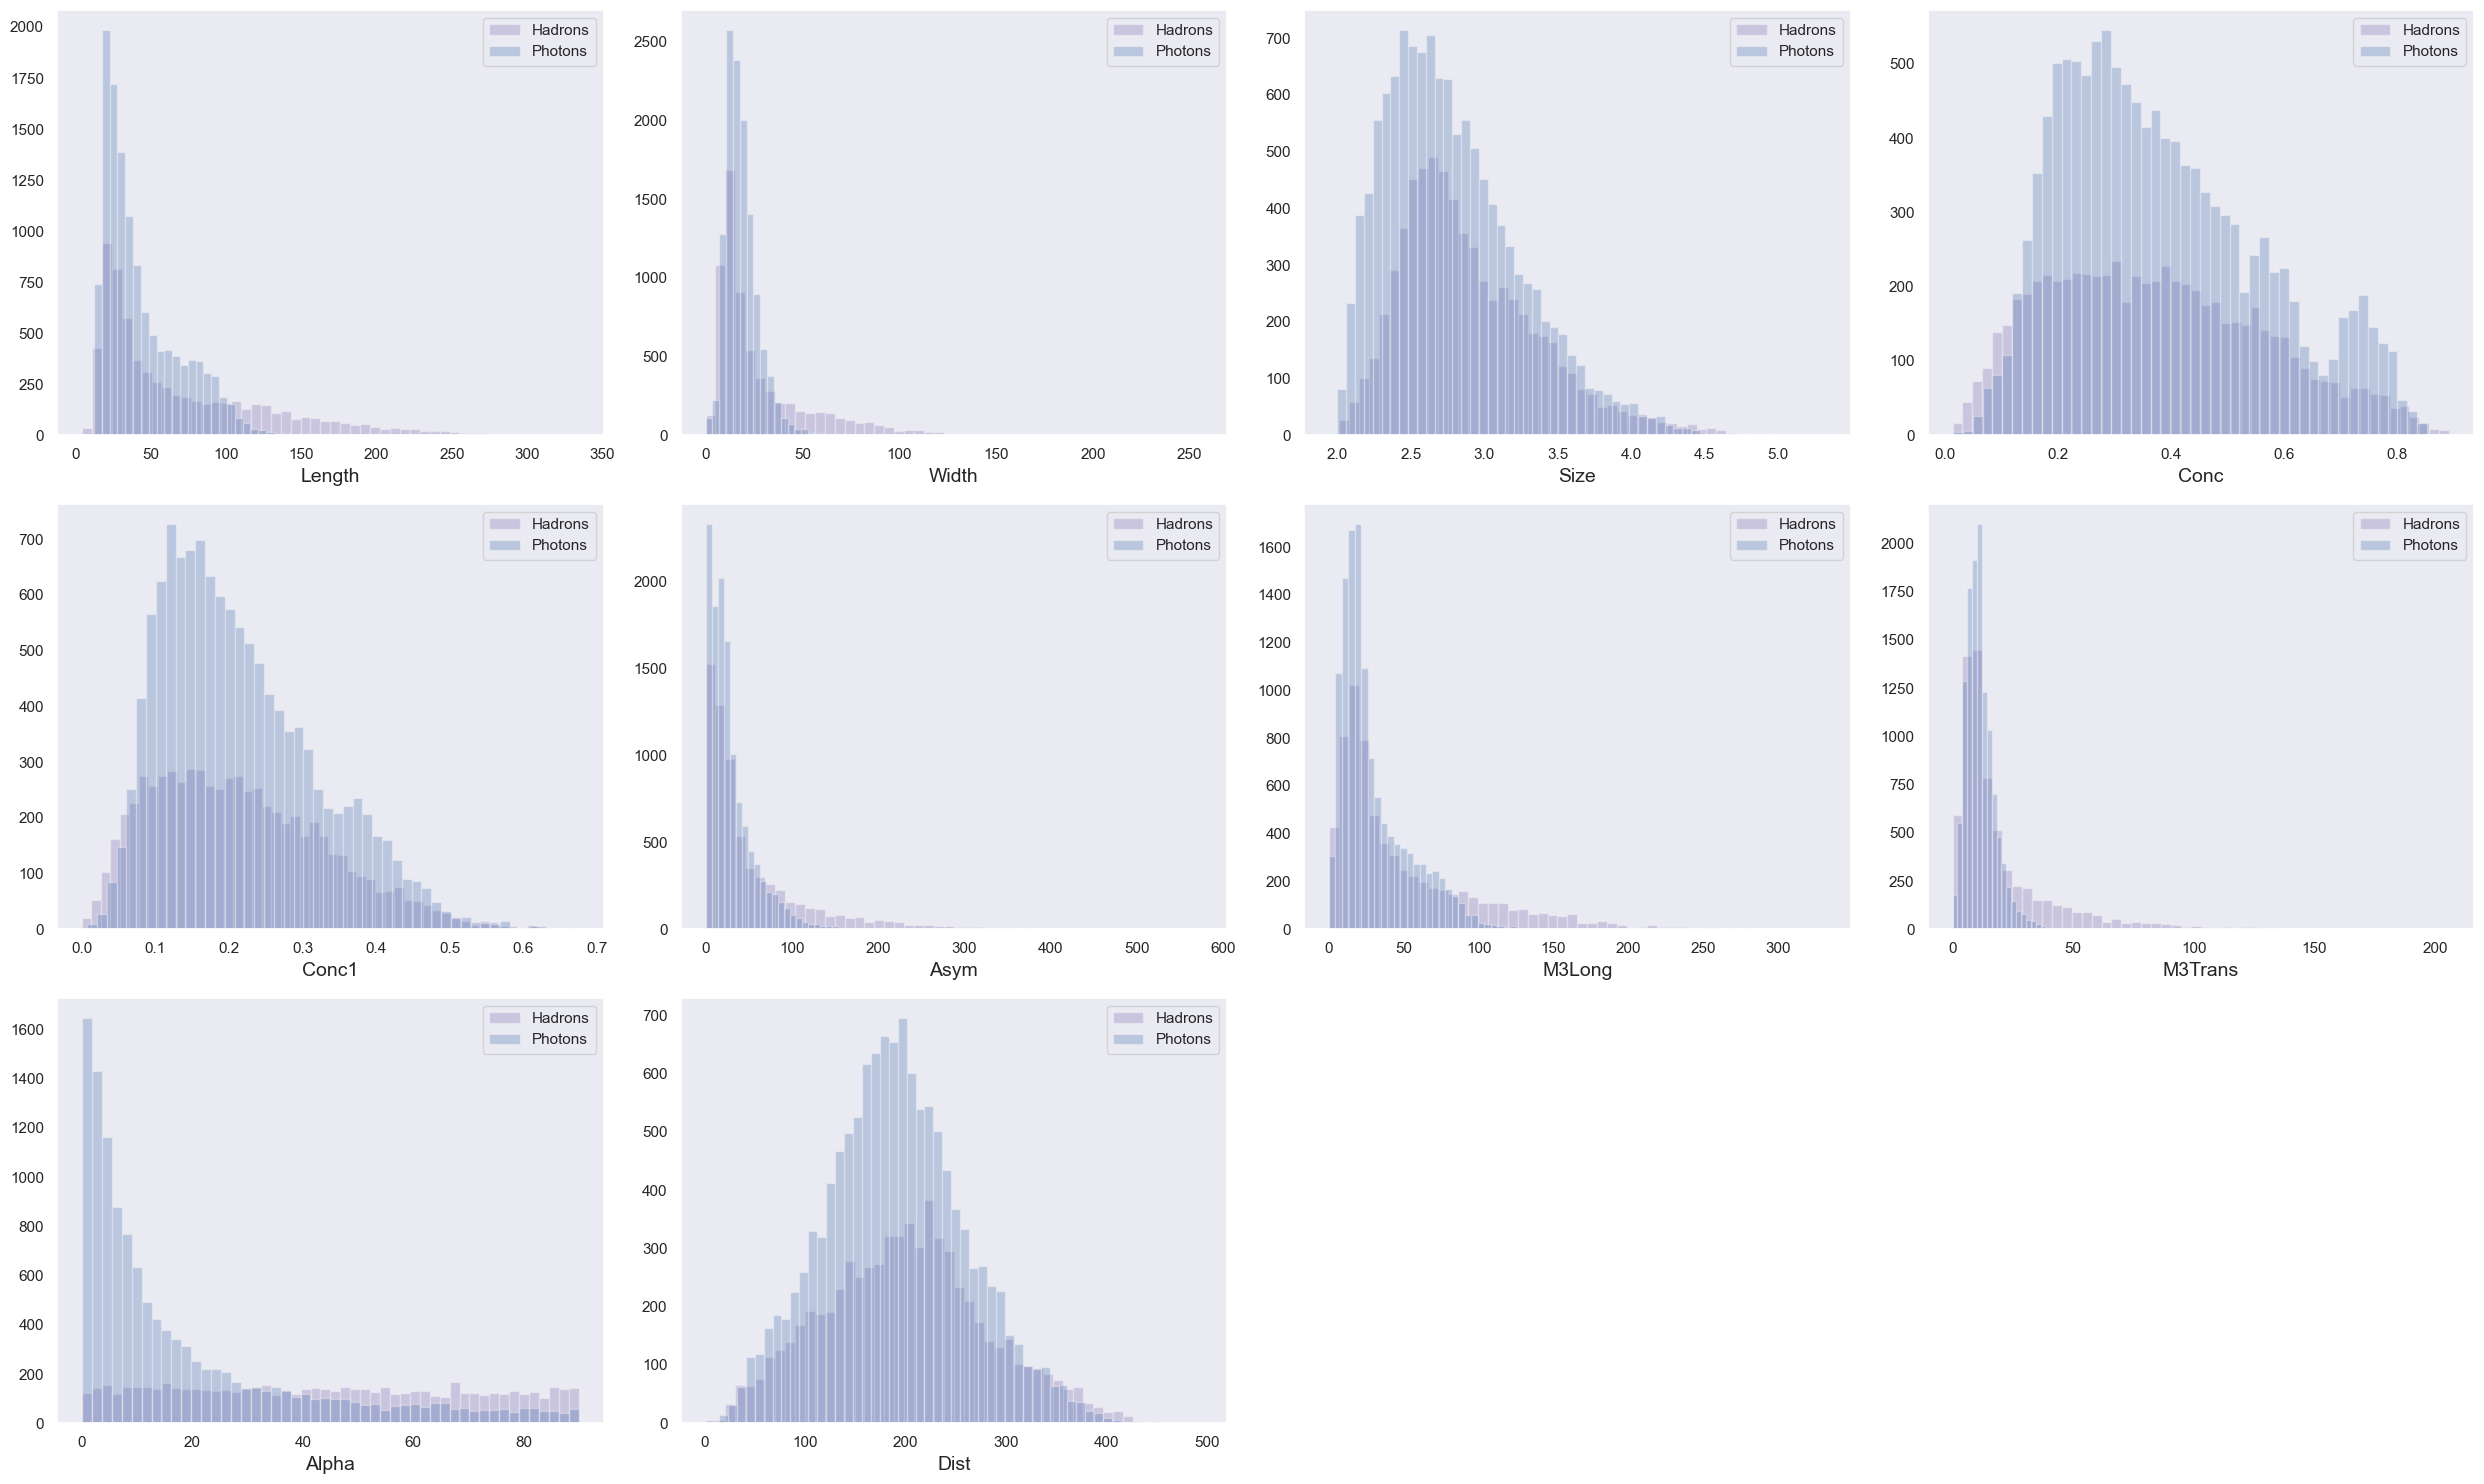

In [7]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

# Обучающая и тестовая выборки

In [8]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify = y, test_size=0.5, shuffle = True, random_state = 11
)

## Задание 1 (0.2 балла)

Проиллюстрируйте распределение y внутри train и test выборки.

In [129]:
def check_y_destribution(y_train, y_test):
    y_train = pd.DataFrame(data=y_train, columns=['y_value'])
    y_test = pd.DataFrame(data=y_test, columns=['y_value'])
    
    fig = plt.figure(figsize=(16, 8))
    sub1 = plt.subplot(1, 2, 1)
    sub1 = y_train['y_value'].value_counts().plot.bar(rot=0)
    sub1.set_title('Train Destribution', fontweight='bold', fontsize=15)
    sub1.legend()
    
    sub2 = plt.subplot(1, 2, 2)
    sub2 = y_test['y_value'].value_counts().plot.bar(rot=0)
    sub2.set_title('Test Destribution', fontweight='bold', fontsize=15)
    sub2.legend()
    
    for sub in [sub1, sub2]:
        for p in sub.patches:
            sub.annotate(
                str(p.get_height()), xy=(p.get_x() + 0.2, p.get_height() + 0.1), fontsize=10, color='r')
    
    plt.suptitle('Y Destribution', fontweight='bold', fontsize=25)
    plt.show()

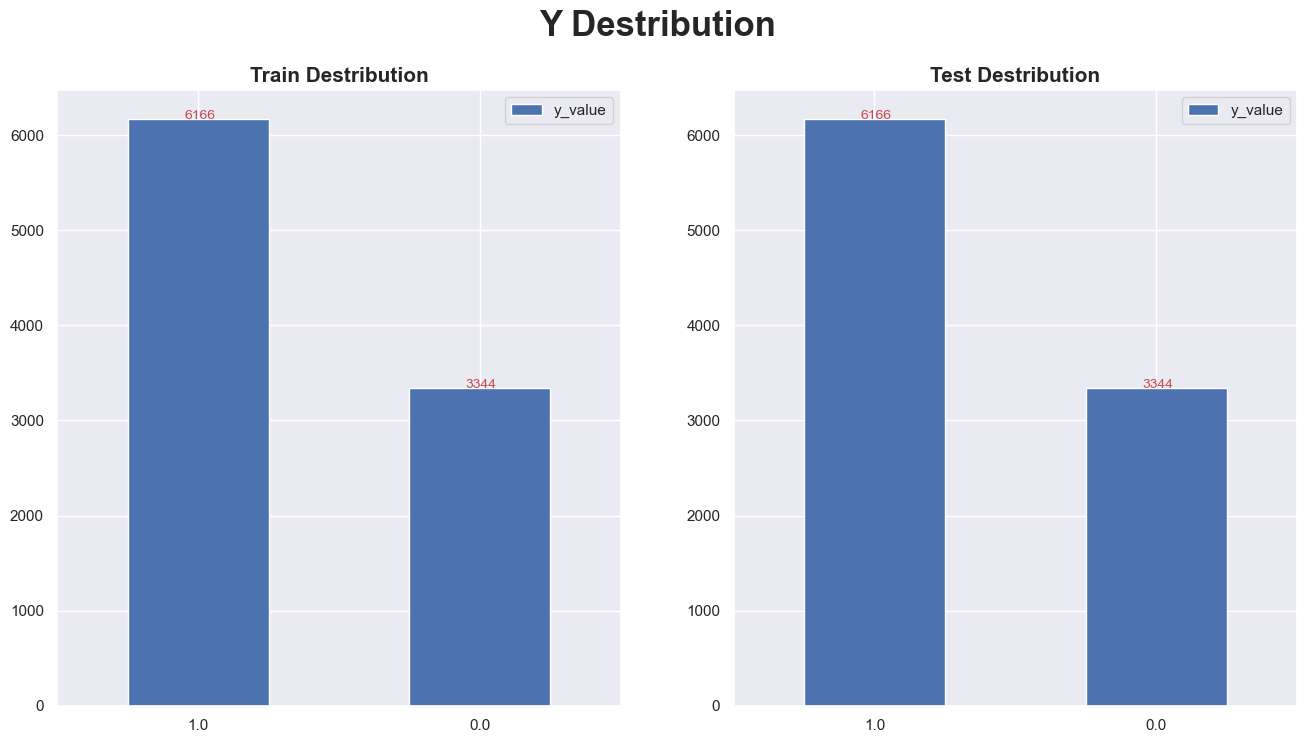

In [130]:
check_y_destribution(y_train=y_train, y_test=y_test)

## Задание 2 (0.8 балл)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [10]:
transformer = sklearn.preprocessing.QuantileTransformer(output_distribution='normal')
X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

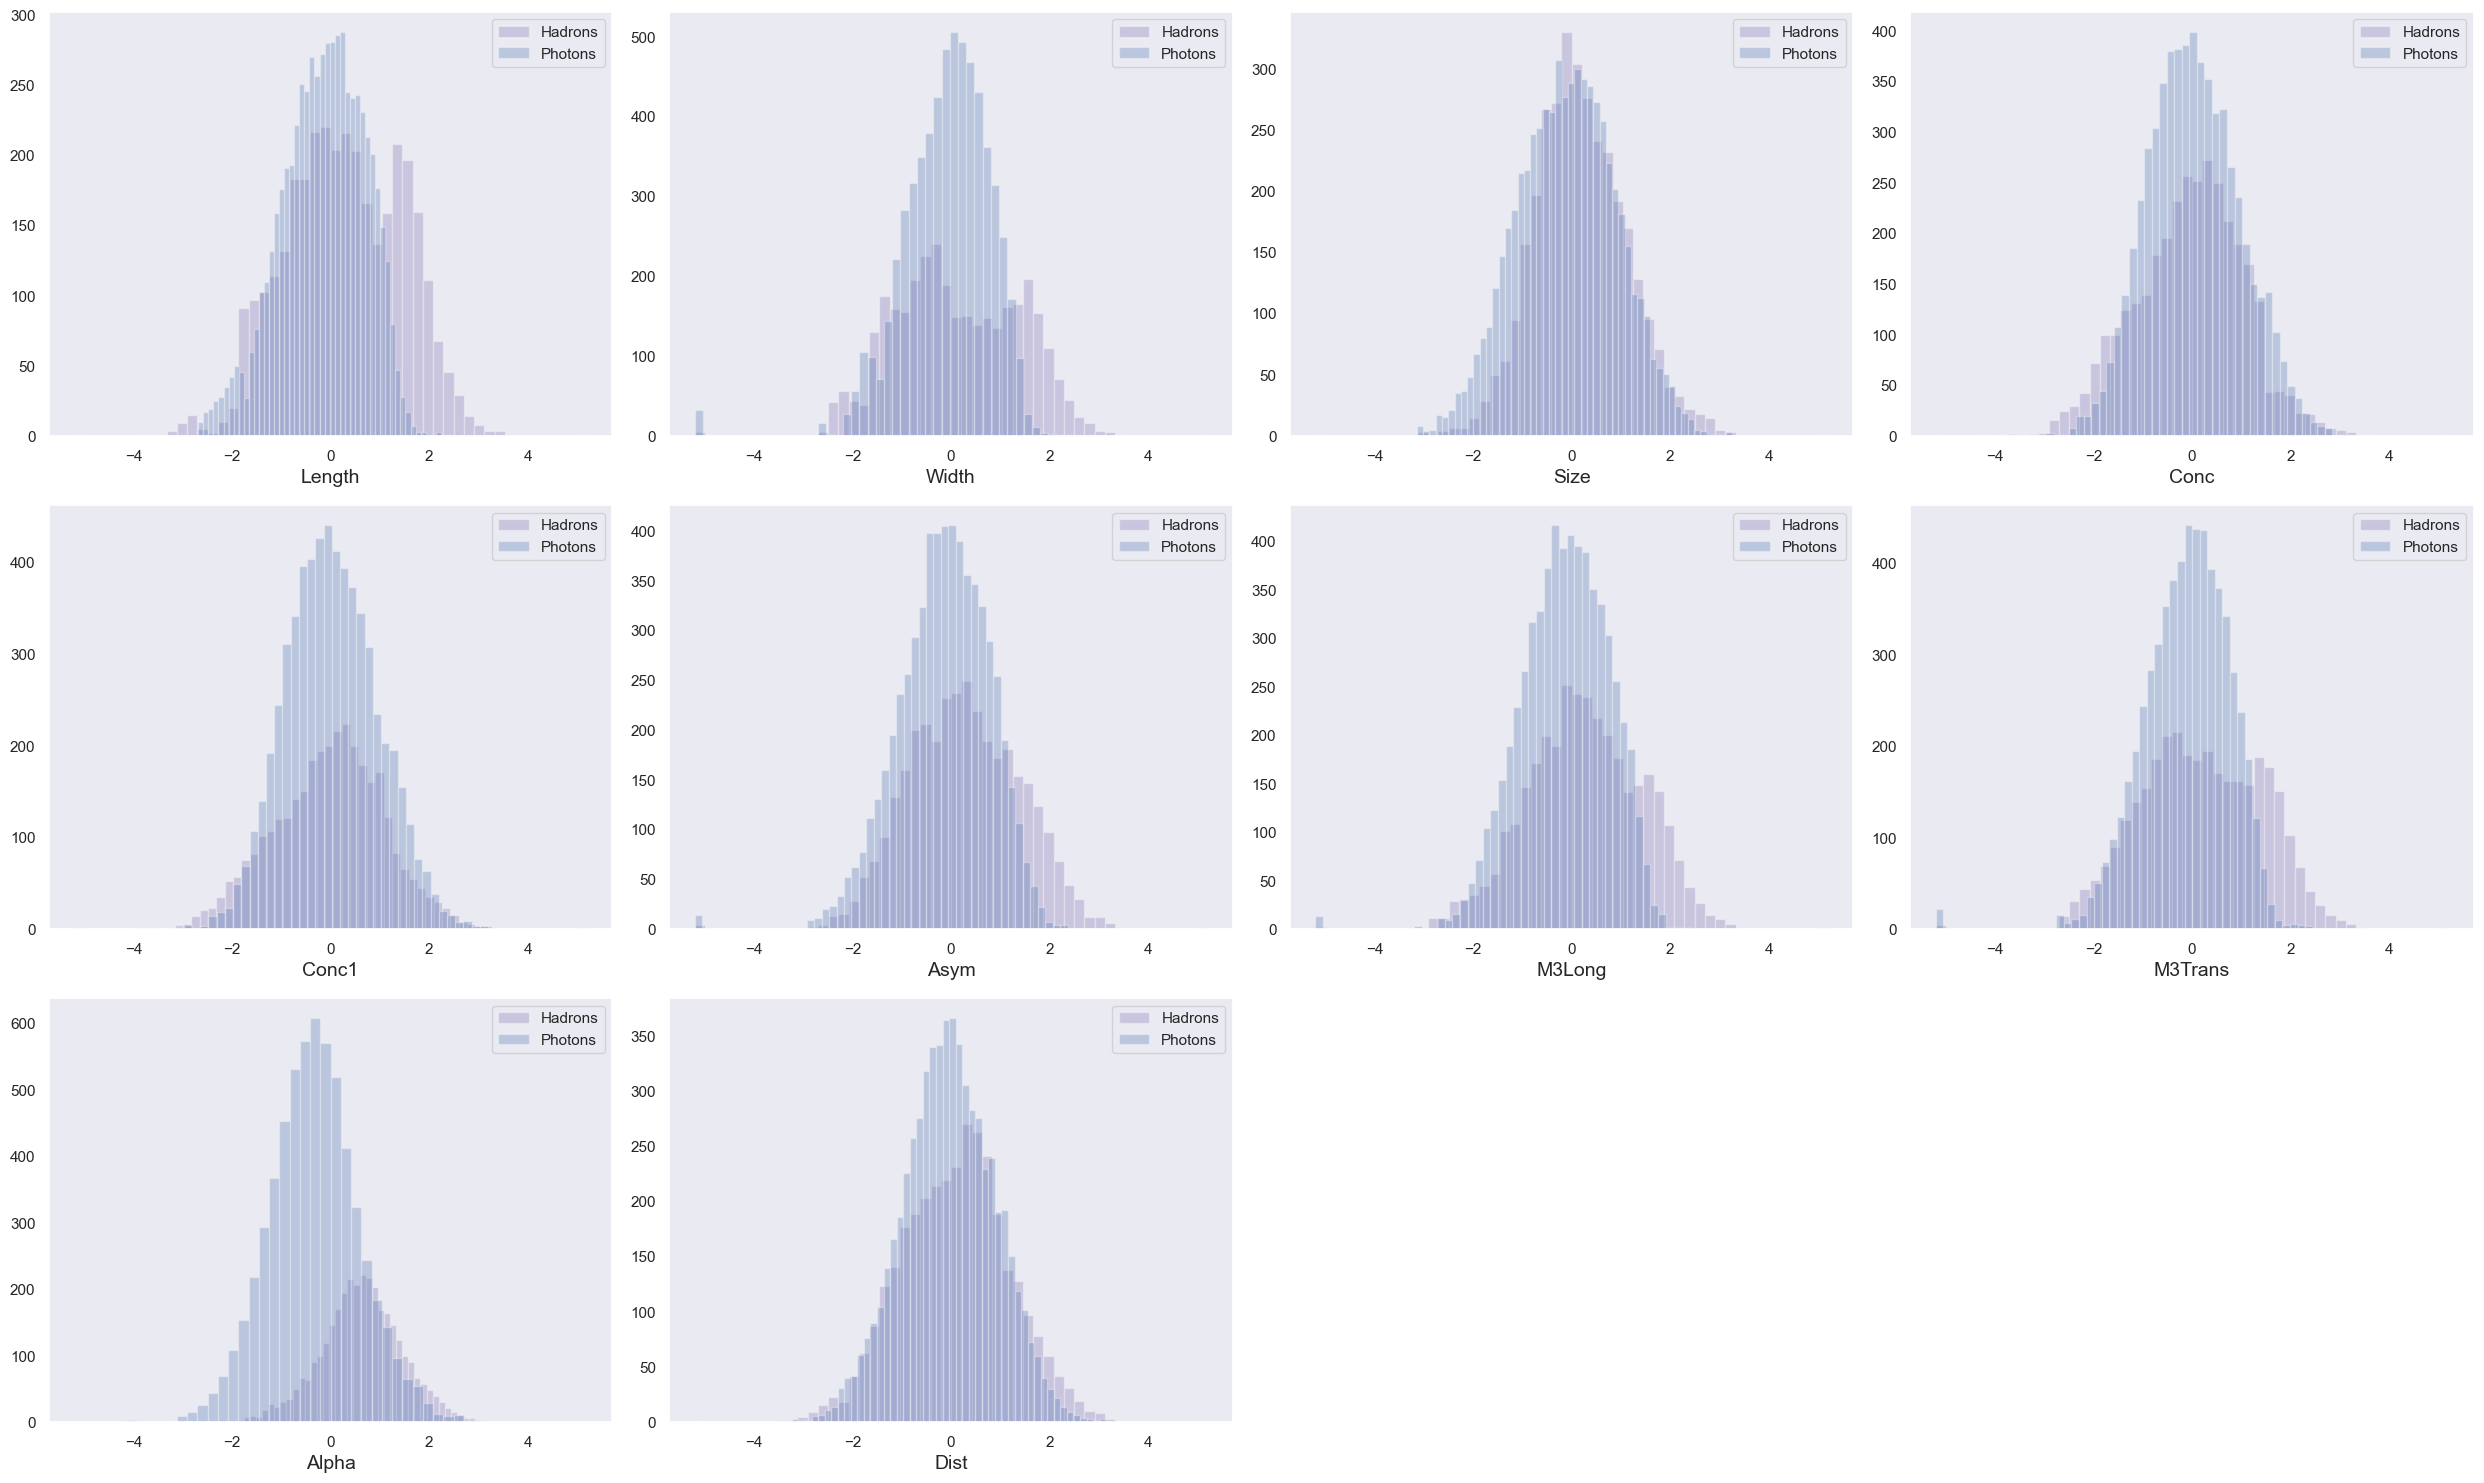

In [11]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

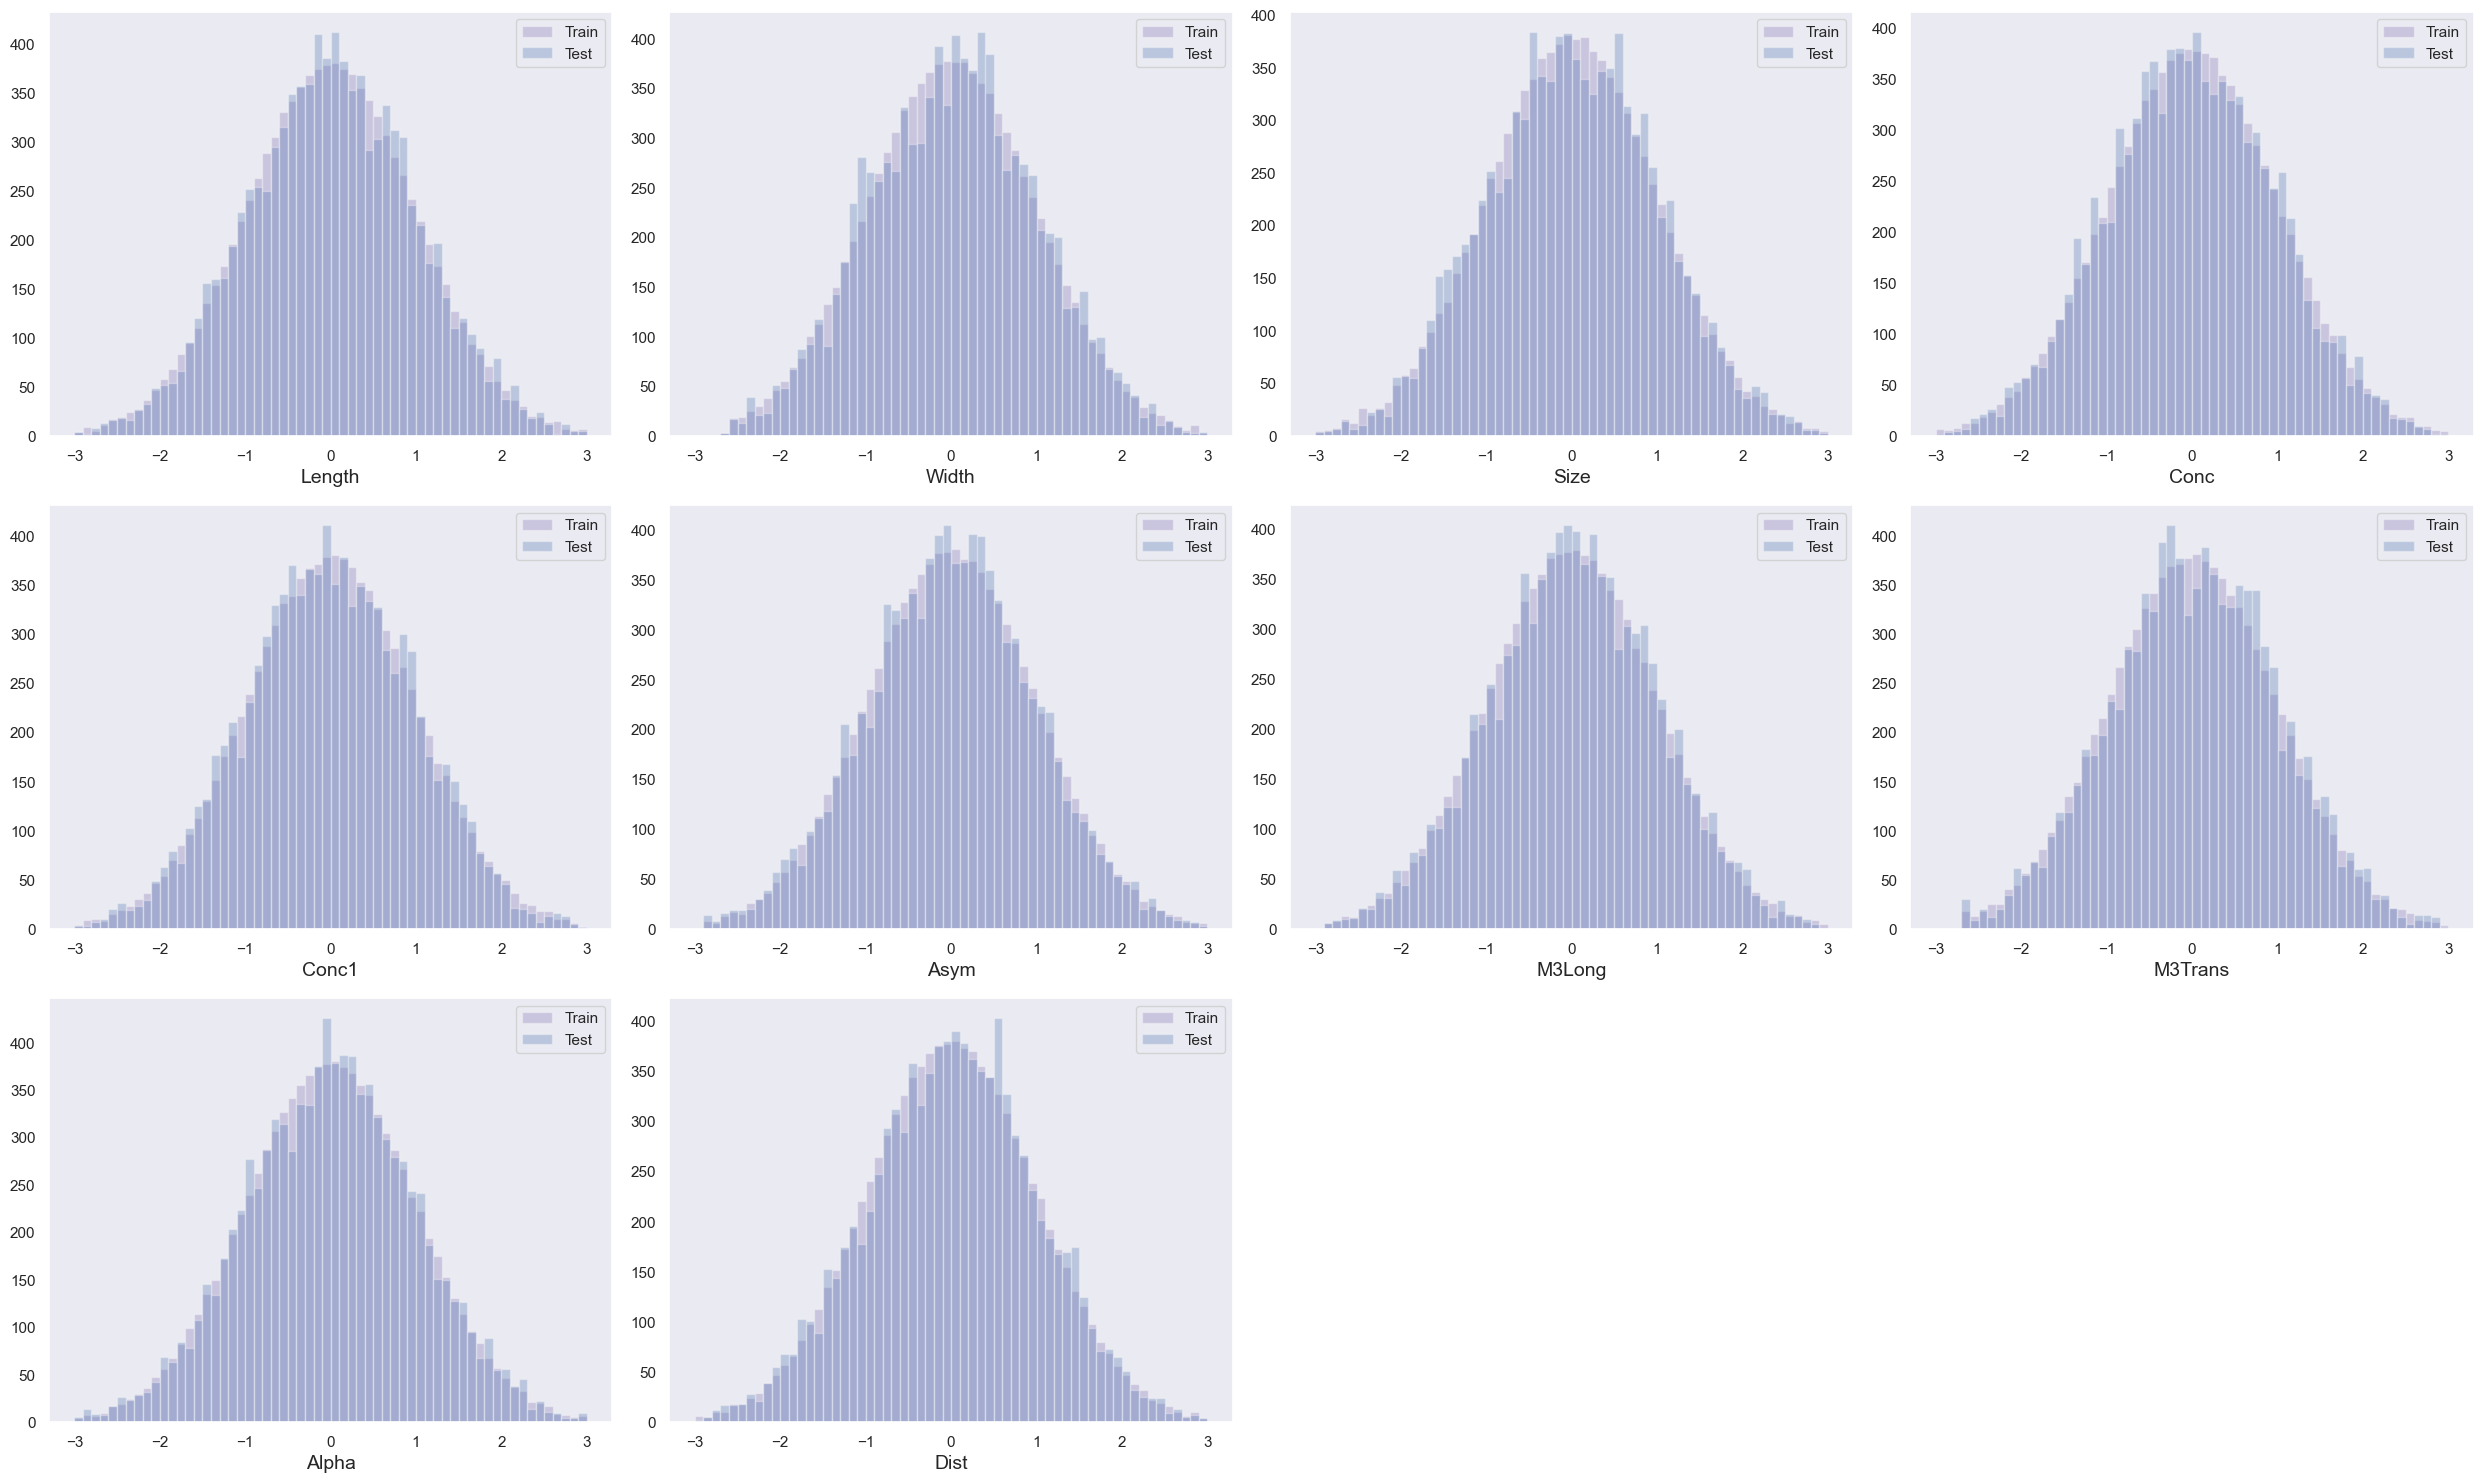

In [12]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения. 

<center><img src="img/cgan.png" width="800"></center>

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$. 

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = \frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + -\frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Connected device is {DEVICE}')

Connected device is cuda


## Задание 3 (0.75 балла)

Реализуйте нейронную сеть для генератора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [14]:
class Generator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()
        
        self.generator = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs)
        )
        
    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        
        output = self.generator(zy)
        return output

## Задание 4 (0.5 балл)

Реализуйте функцию для генерации новый объектов $X$ по вектору условий $y$.

In [15]:
def generate(generator, y, latent_dim):
    if not isinstance(y, torch.Tensor):
        y = torch.tensor(data=y, dtype=torch.float, device=DEVICE)
    noise = torch.normal(0, 1, size=(y.shape[0], latent_dim)).to(DEVICE)
    X_fake = generator(noise, y)
    return X_fake

## Задание 5 (0.75 балла)

Реализуйте нейронную сеть для дискриминатора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

Какая функция активации должна быть в конце работы модели и почему? А она вообще тут должна быть? Обоснуйте свой выбор.

In [16]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()
        
        self.discriminator = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        output = self.discriminator(xy)
        return output

Сигмоида в качетсве функции активации была выбрана для того, чтобы "сжать" выходы до значний (0, 1) для вывода меток классов

## Задание 6 (0.5 балла)

Реализуйте функцию, которая принимала бы на вход набор сгенерированных и настоящих объектов, разбивала на train и test с учетом баланса классов (real и fake объектов), с соотношением 3 к 1, обучала модель линейной регрессии и градиентного бустинга, которые учились бы отличать настоящие объекты от фальшивых, после чего выводила бы accuracy score на отложенной выборке у обоих моделей.

Ответьте на вопрос: какое значение accuracy score нас бы удовлетворило больше всего? Почему?

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

def other_agent_score(X_real: np.ndarray, y_real: np.ndarray, X_fake: np.ndarray, y_fake: np.ndarray):
    X_real = X_real[0]
    X_fake = X_fake[0]
    
    features = np.concatenate((X_real, X_fake), axis=0)
    conditions = np.concatenate((y_real, y_fake), axis=0)

    X_train, X_test, y_train, y_test = train_test_split(
        features, conditions, stratify=conditions, test_size=0.25, 
        shuffle=True, random_state=11
    )
    log_reg = LogisticRegression().fit(X_train, y_train)
    boosting = GradientBoostingClassifier().fit(X_train, y_train)
    
    log_reg_pred = log_reg.predict(X_test)
    boosting_pred = boosting.predict(X_test)
    
    log_reg_score = sklearn.metrics.accuracy_score(y_test, log_reg_pred)
    boosting_score = sklearn.metrics.accuracy_score(y_test, boosting_pred)
    
    print('Linear regression score: ' + str(log_reg_score))
    print('Boosting score: ' + str(boosting_score))

### 1. Я считаю, чем меньше у нас значение accuracy score, тем лучше, так как чем меньше процент правильных ответов у модели (классификатора в нашем случае), тем хуже она справляется с разбиением данных на классы (в нашем случае сгенерированные моделью и реальные), а значит наша модель может мимикрировать реальные данные так, чтобы модель (классификатор в нашем случае) затруднялась ответить на вопрос: "Какое из этих наблюдений реальное, а какое фейковое?".

## Задание 7 (1.5 балла)

Реализуйте класс для обучения генеративной модели.

- Подсказка 1: не забывайте ограничивать веса дискриминатора. Для этого используйте `p.data.clamp_(-0.01, 0.01)`, где `p` веса дискриминатора.
- Подсказка 2: `n_critic` - число итераций обучения дискриминатора на одну итерацию обучения генератора.
- Подсказка 3: Используйте `X_tensor = torch.tensor(X_numpy, dtype=torch.float, device=DEVICE)` для перевода numpy в тензор.

$$L(G, D) = 
\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + -\frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [18]:
class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size = 32,
        n_epochs = 10,
        latent_dim = 1,
        lr = 0.0001,
        n_critic=5,
    ):

        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)
        self.verbose_num_iters = 200

    def fit(self, X, y):
        
        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)

        self.loss_history = []
        generator_loss_trace = []
        discriminator_loss_trace = []
        
        iteration = 0
        # Fit GAN
        for epoch in range(self.n_epochs):
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                ### YOUR CODE IS HERE ######
                noise_batch = torch.normal(0, 1, (len(real_batch), self.latent_dim)).to(DEVICE)
                fake_batch = self.generator(noise_batch, cond_batch)
                
                if (iteration % (1 + self.n_critic)) < 1:
                    self.opt_gen.zero_grad()
                    
                    generator_loss = torch.mean(self.discriminator(fake_batch, cond_batch))
                    generator_loss.backward()

                    self.opt_gen.step()
                    generator_loss_trace.append((iteration, generator_loss.item()))
                    
                else:
                    self.opt_disc.zero_grad()
                    
                    discriminator_loss = torch.mean(self.discriminator(real_batch, cond_batch)) - torch.mean(self.discriminator(fake_batch, cond_batch))
                    discriminator_loss.backward()  
                    self.opt_disc.step()
                    with torch.no_grad():
                        for param in self.discriminator.parameters():
                            param.data.clamp_(-.01, .01)
                                 
                    discriminator_loss_trace.append((iteration, discriminator_loss.item()))
                    
                iteration += i
                ### THE END OF YOUR CODE ###
        
            # calculate and store loss after an epoch
            Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim)).to(DEVICE)
            X_fake = self.generator(Z_noise, y_cond)
            loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(
                self.discriminator(X_fake, y_cond)
            )
            self.loss_history.append(loss_epoch.detach().cpu())
            
            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов 
            # И запустите работу фукнции other_agent_score
            
            ### YOUR CODE IS HERE ######
            random_indices = torch.randint(low=0, high=X_real.shape[0], size=(1, 1000))
            random_real_features_scores = X_real[random_indices].detach().clone().cpu().numpy()
            random_fake_features_scores = X_fake[random_indices].detach().clone().cpu().numpy()
            random_real_condition = np.ones(1000)
            random_fake_condition = np.zeros(1000)
            
            other_agent_score(X_real=random_real_features_scores, y_real=random_real_condition,
                              X_fake=random_fake_features_scores, y_fake=random_fake_condition)
            
            
            ### THE END OF YOUR CODE ###
            
        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

## Обучение
Обучим модель на данных.

In [19]:
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1])

In [20]:
%%time

fitter = Fitter(
    generator,
    discriminator,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
fitter.fit(X_train, y_train)

Linear regression score: 0.666
Boosting score: 0.98
Linear regression score: 0.656
Boosting score: 0.956
Linear regression score: 0.688
Boosting score: 0.94
Linear regression score: 0.692
Boosting score: 0.924
Linear regression score: 0.73
Boosting score: 0.934
Linear regression score: 0.69
Boosting score: 0.918
Linear regression score: 0.606
Boosting score: 0.918
Linear regression score: 0.63
Boosting score: 0.882
Linear regression score: 0.614
Boosting score: 0.878
Linear regression score: 0.666
Boosting score: 0.834
Linear regression score: 0.632
Boosting score: 0.84
Linear regression score: 0.71
Boosting score: 0.862
Linear regression score: 0.57
Boosting score: 0.762
Linear regression score: 0.594
Boosting score: 0.766
Linear regression score: 0.632
Boosting score: 0.786
Linear regression score: 0.65
Boosting score: 0.798
Linear regression score: 0.622
Boosting score: 0.802
Linear regression score: 0.634
Boosting score: 0.74
Linear regression score: 0.592
Boosting score: 0.718
Lin

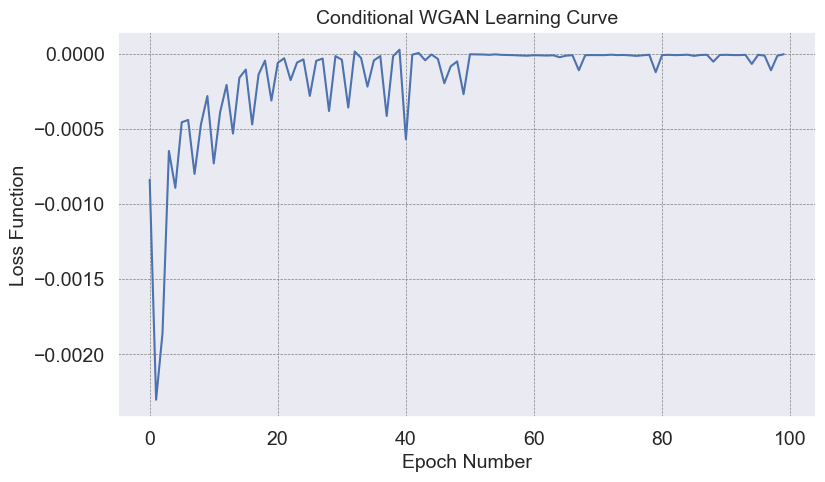

In [21]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 8 (0.5 балла)

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`. Перед сравнением результатов сделайте обратное квантильное преобразование с помощью трансформера, который вы обучили в задании 2.

In [22]:
X_fake_train = generate(fitter.generator, y_train, latent_dim).detach().clone().cpu().numpy()
X_train = transformer.inverse_transform(X_train)
X_fake_train = transformer.inverse_transform(X_fake_train)

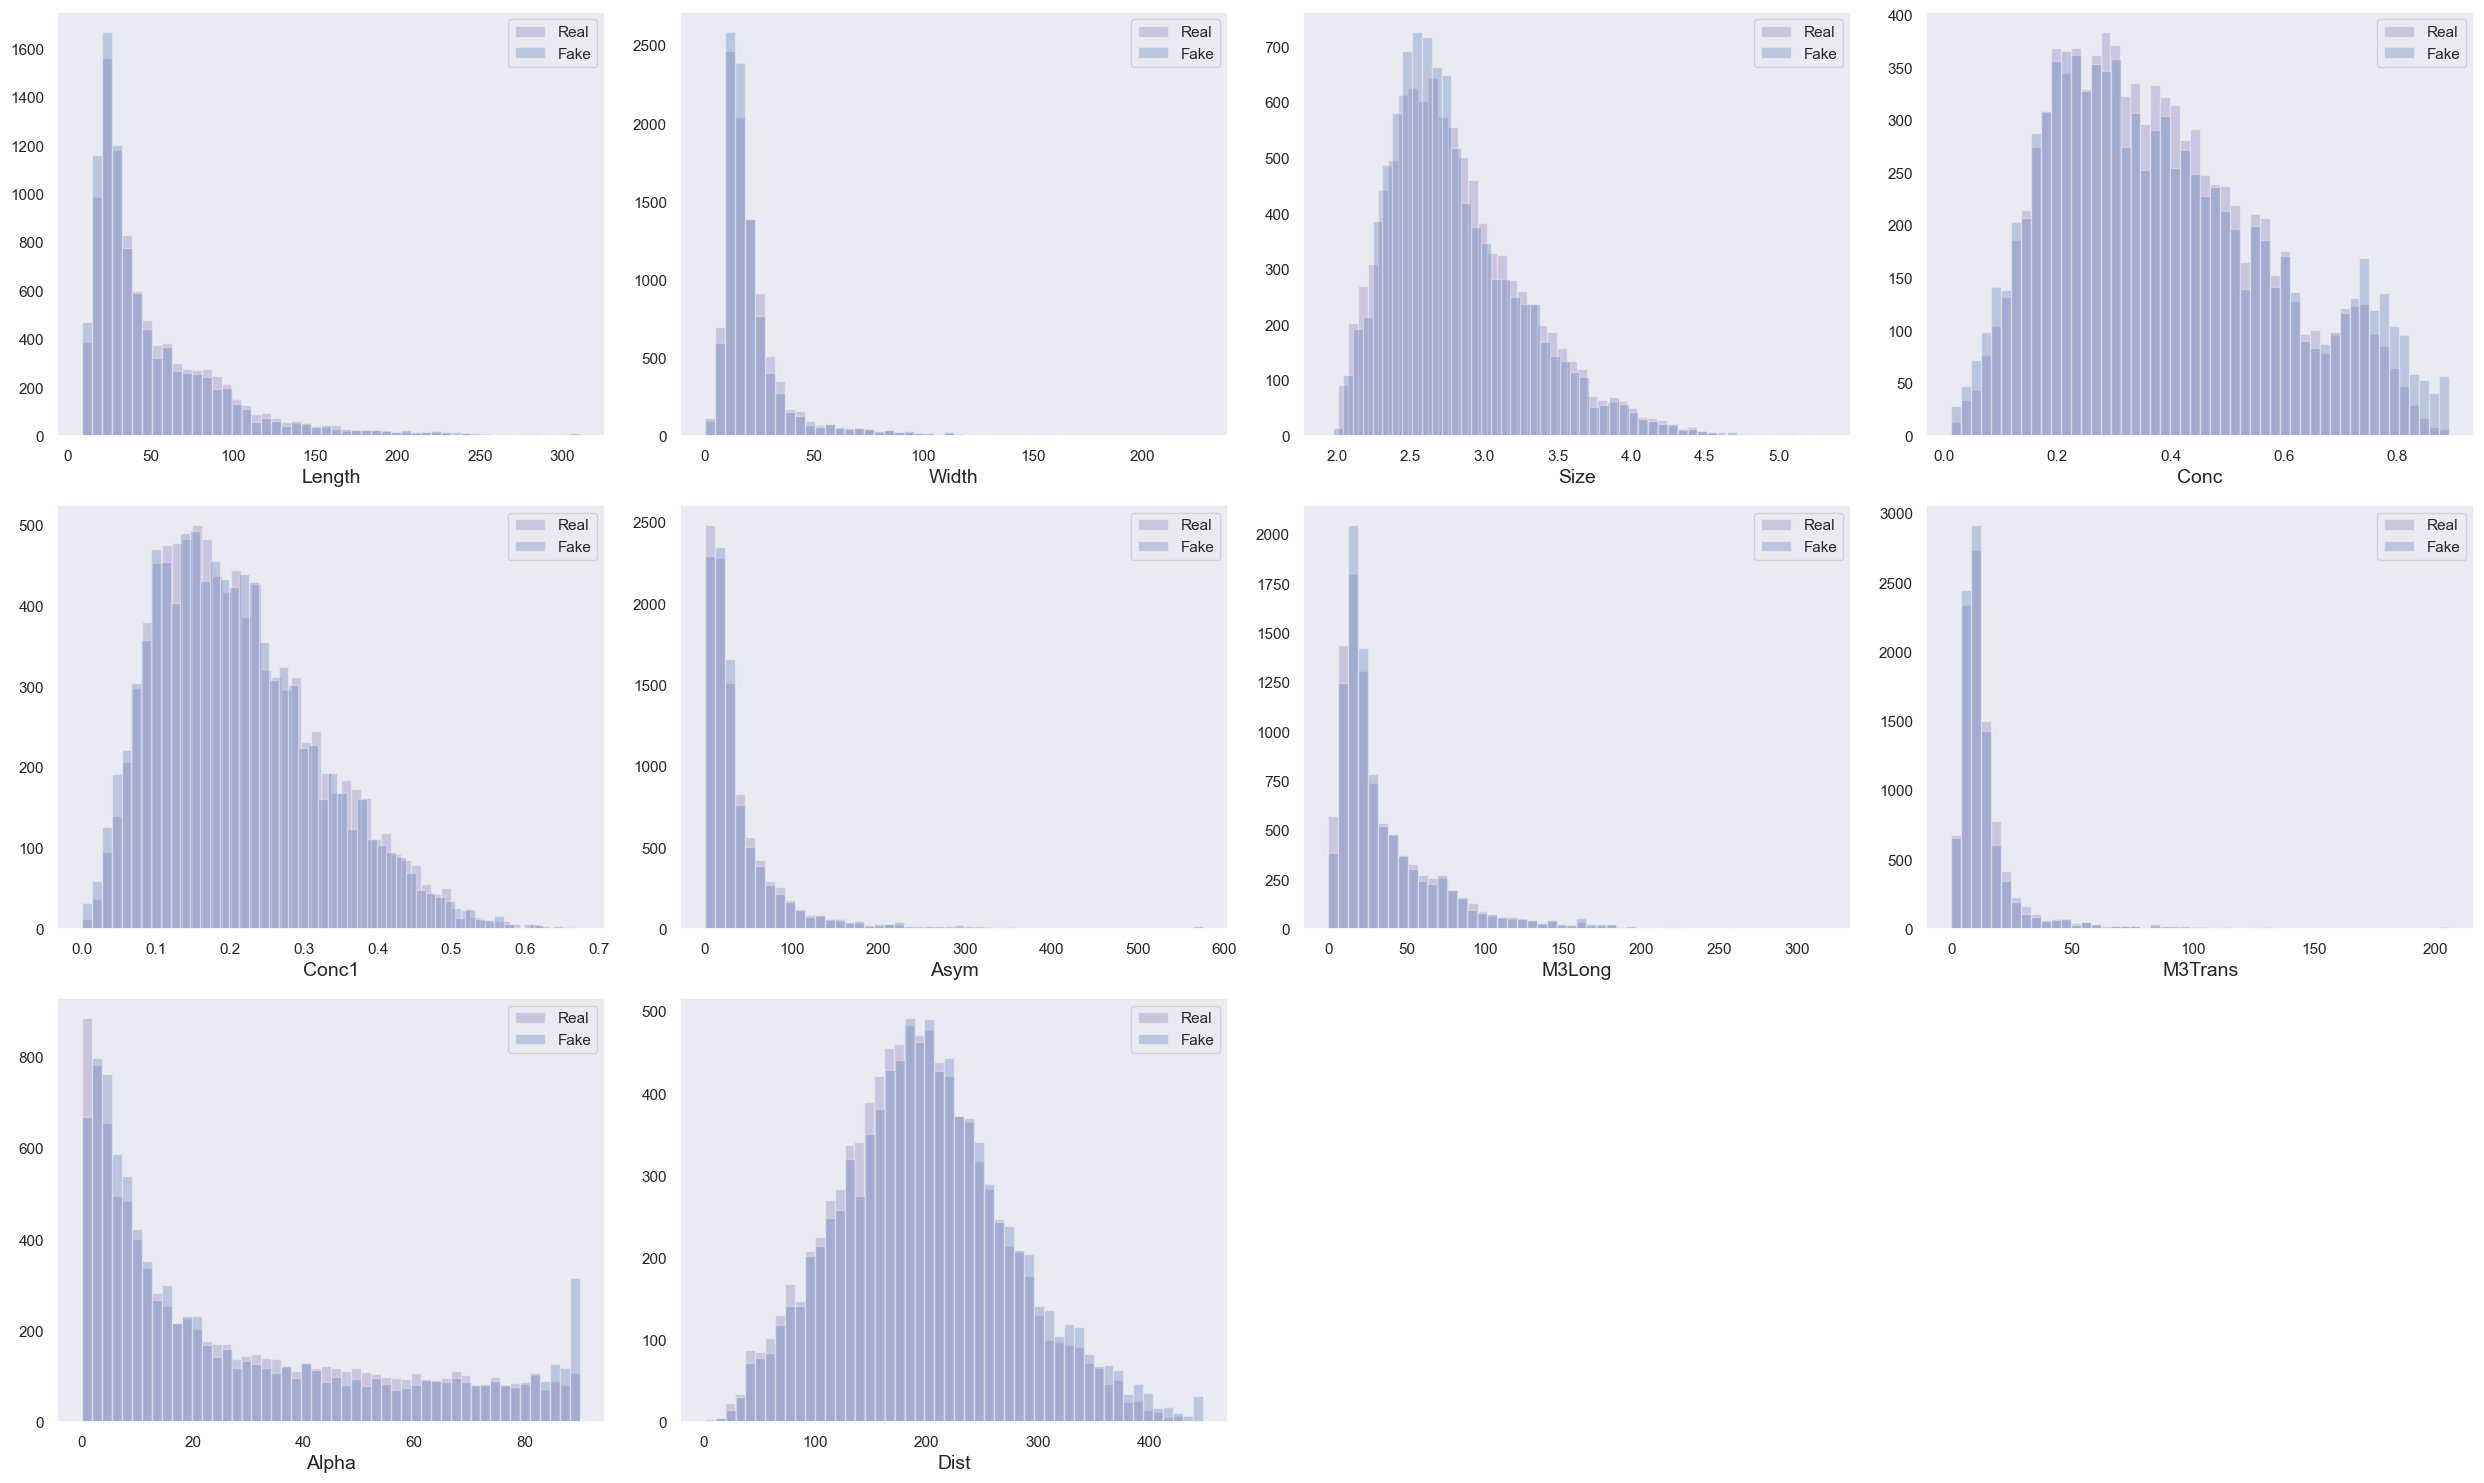

In [23]:
plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [24]:
X_fake_test = generate(fitter.generator, y_test, latent_dim).detach().clone().cpu().numpy()
X_test = transformer.inverse_transform(X_test)
X_fake_test = transformer.inverse_transform(X_fake_test)

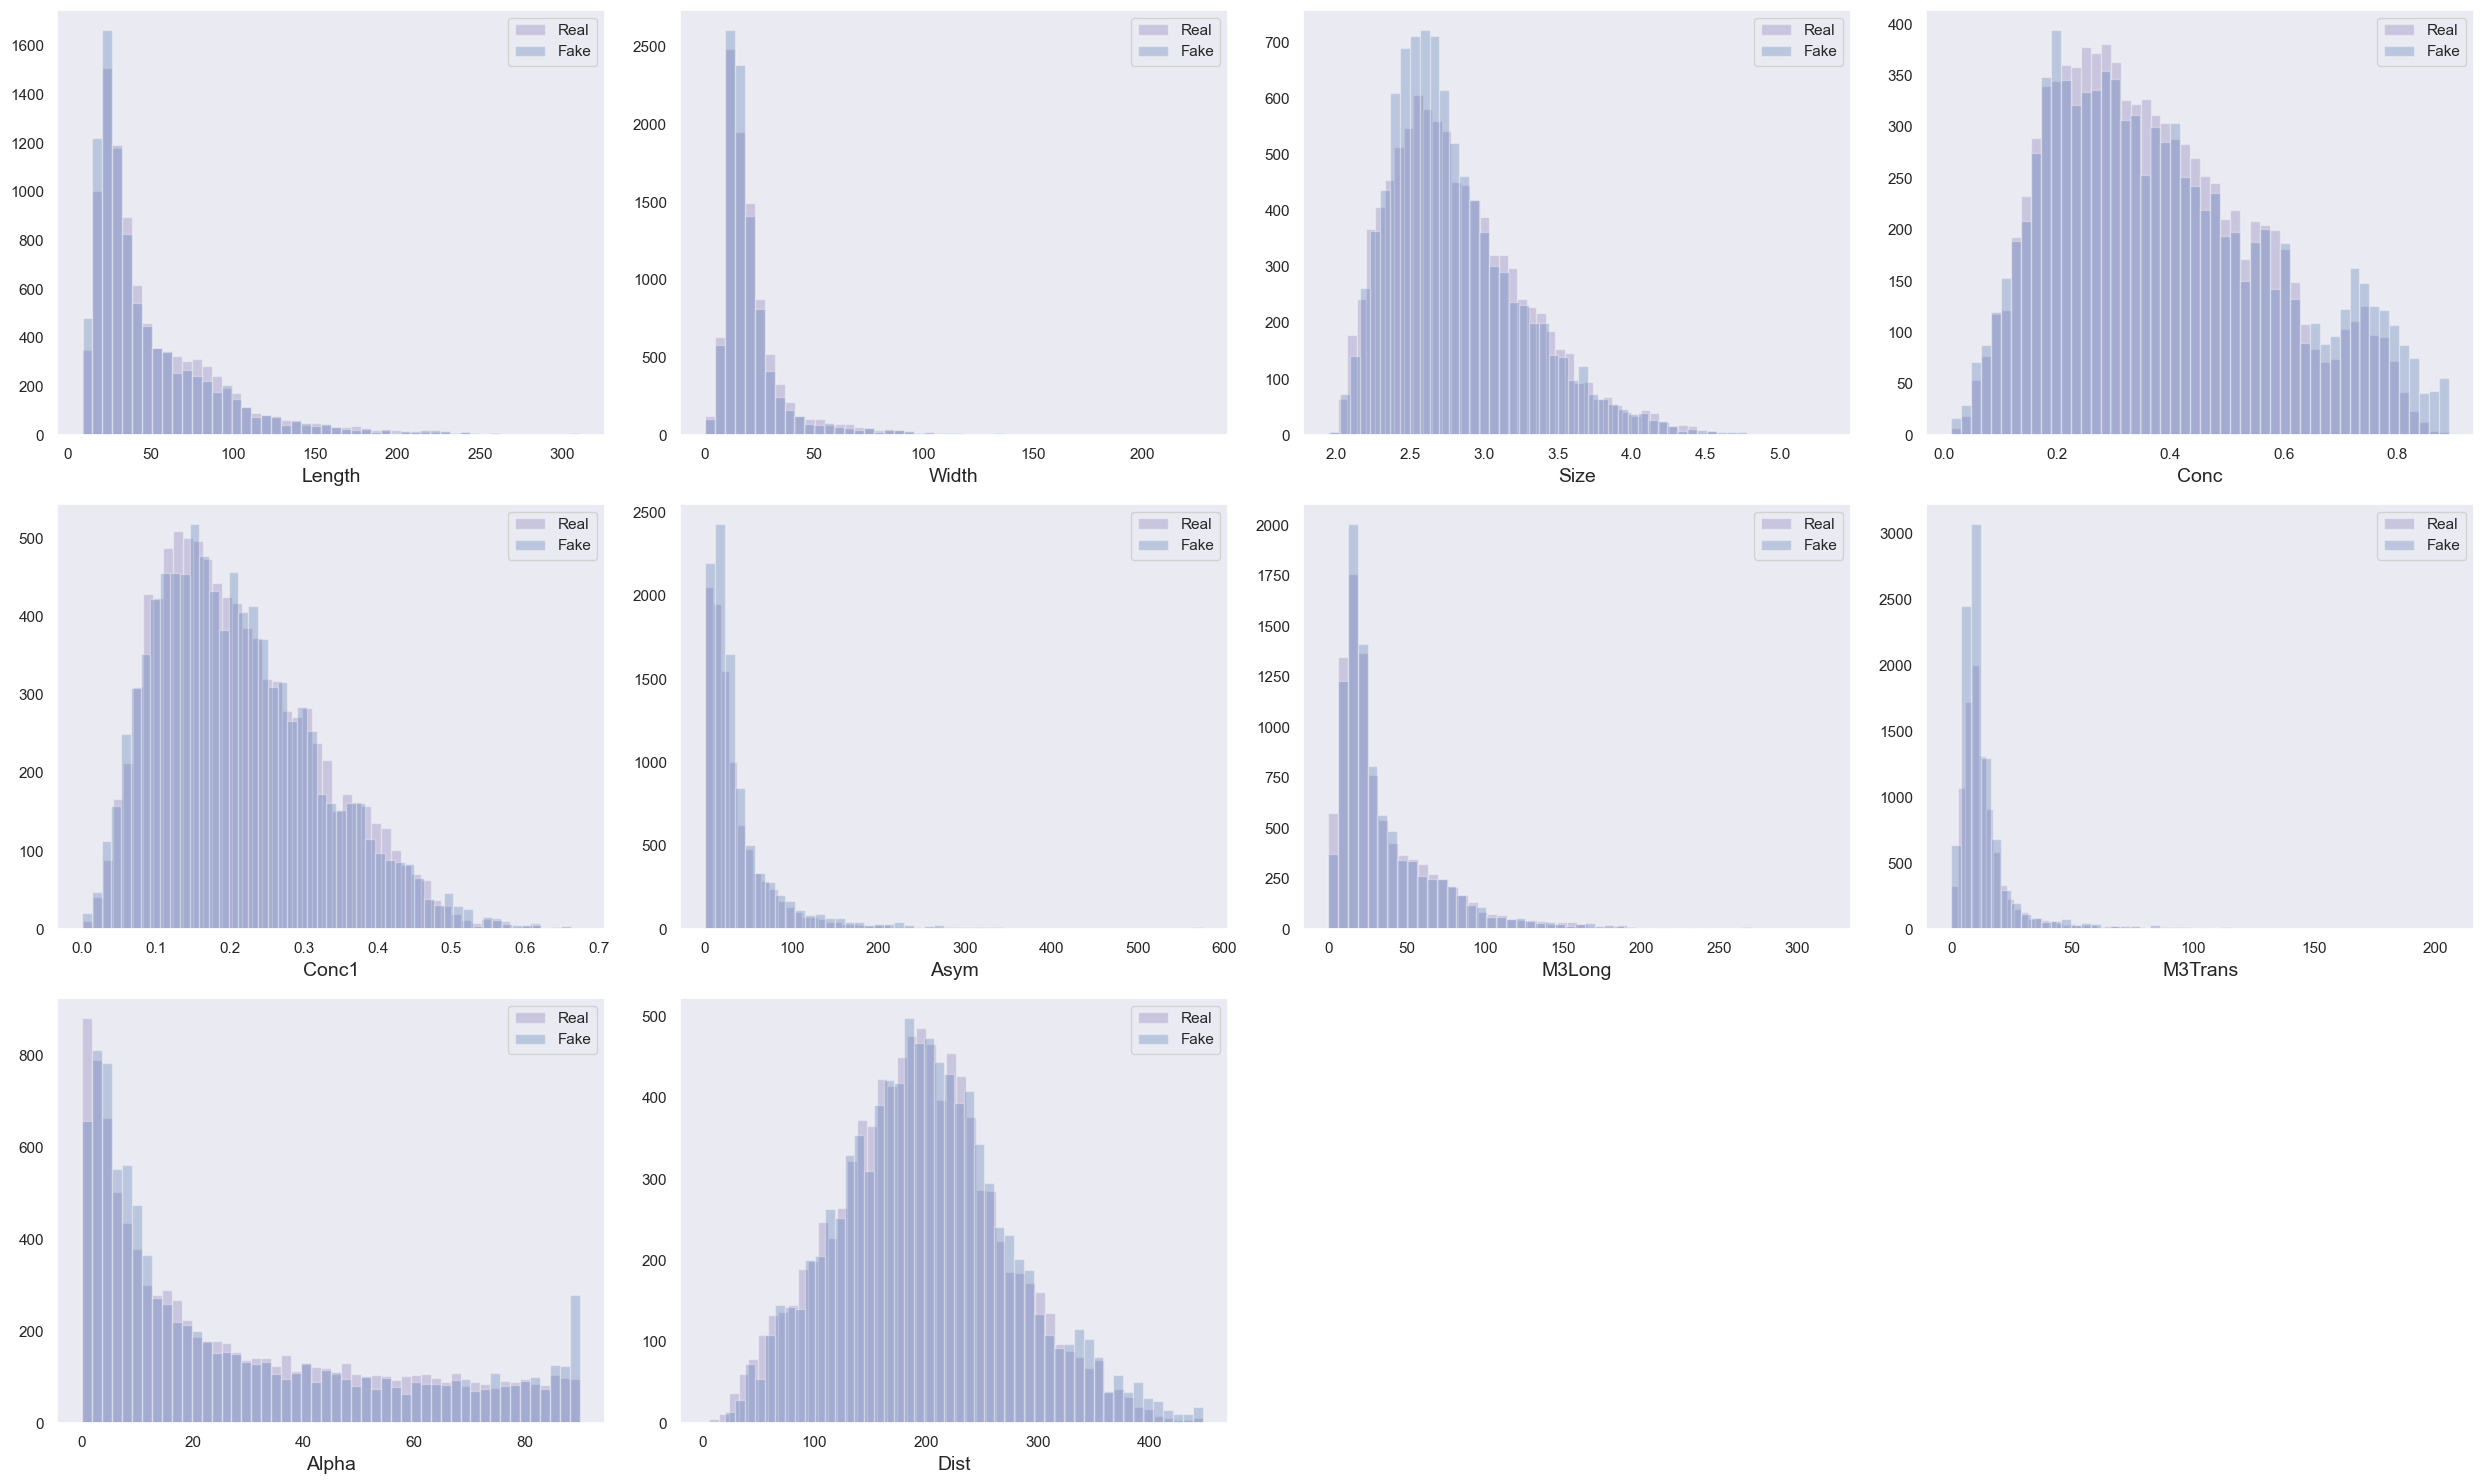

In [25]:
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

## Вывод: 
Визуально мы видим сходство реальных и фейковых данных. Однако это только проекции 10-мерных объектов на одну ось.

# Измерение качества генерации

<center><img src="img/clf.png" width="600"></center>

Измерим сходство распределений классификатором.

In [26]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [27]:
# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [28]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.8299637992439195


## Задание 9 (0.5 балла)

Опишите ваш эксперимент. Как вы оцениваете полученные результаты? Как вы думаете, какое значение ROC AUC нас удовлетворяет больше всего? Почему?


### 1. Если мы смогли нормально разбить нашу настоящую и фековую выборки (так как ROC AUC достаточно высокий), значит наша состязательная модель плохо справилась с генерацией объектов, похожих на реальные(

### 2. Я считаю, что ROC AUC должен быть меньше 0.5 (может быть), так как это будет означать, что наше фейковые данные (сгенерированные) сложно будет отличить от реальных и классификатор на градиентном бустинге будет ошибаться в ~50% случаев 


## Диффузионные модели.

Давайте теперь проведем такой же экперимент с простой диффузионной моделью.

## Задание 10 (0.5 балла)

Реализуйте фукнцию из семинара для зашумления данных, адаптировав ее под наш тип данных.

In [29]:
def corrupt(x, amount):
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1)
    return (1 - amount)*x + amount*noise

## Добавим sсheduler, он пригодится вам при обучении модели

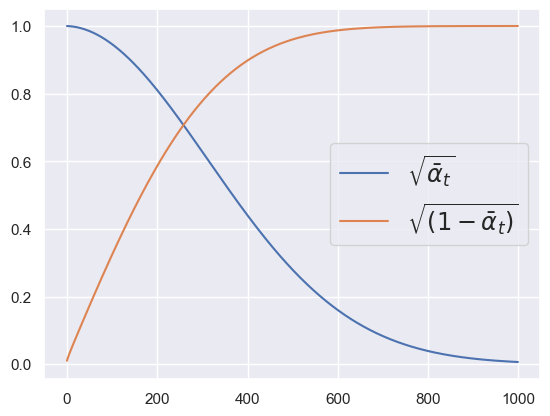

In [30]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large")
plt.show()

## Задание 11 (0.5 балла)

Реализуйте нейронную сеть. В качетсве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?). 

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [31]:
class Conv1d_block(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv1d(in_channels=in_channels, out_channels=out_channels,
                      kernel_size=(3, 3), bias=False),
            nn.BatchNorm1d(out_channels),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=out_channels, out_channels=out_channels,
                      kernel_size=(3, 3), bias=False),
            nn.BatchNorm1d(out_channels),
            nn.LeakyReLU(),
        )
    
    def forward(self, x):
        return self.conv_block(x)

class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs: Optional[int] = None, n_outputs: Optional[int] = None, 
                 in_channels: Optional[int] = 1, out_channels: Optional[int] = 1,
                 features: List[int] = [32, 64, 128]):
        super(DiffusionGenerator, self).__init__()
        
        self.down_block = nn.ModuleList([])
        self.up_block = nn.ModuleList([])
        
        for feature in features:
            self.down_block.append(Conv1d_block(in_channels=in_channels, out_channels=feature))
            in_channels = feature
            
            self.up_block.append(Conv1d_block(in_channels=feature*2, out_channels=feature))
        
        self.bottleneck = Conv1d_block(in_channels=features[-1], 
                                            out_channels=features[-1]*2)
        self.final_conv = nn.Conv1d(in_channels=features[0], out_channels=out_channels, kernel_size=(1, 1))
        self.downsample = nn.MaxPool1d(kernel_size=(2, 2))

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        
        skip_connections = []
        for down_layer in self.down_block:
            zy = down_layer(zy)
            skip_connections.append(zy)
            zy = self.downsample(zy)
        zy = self.bottleneck(zy)
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.up_block), 2):
            zy = self.up_block[idx](zy)
            skip_connection = skip_connections[idx // 2]
            if zy.shape != skip_connection.shape:
                zy = transforms.functional.resize(zy, size=skip_connection.shape[2:])
            concat_skip = torch.cat(
                (skip_connection, zy), dim=1
            )
            zy = self.up[idx + 1](concat_skip)
        return self.final_conv(zy)

In [32]:
print(f"Количество параметров в сети: \
{sum([p.numel() for p in DiffusionGenerator().parameters()])}",
end='')

Количество параметров в сети: 1754177

### Качество буду измерять также по ROC AUC, ради чистоты эксперимента (чем меньше - тем лучше)

## Задание 12 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

In [33]:
def generate_with_diffusion(model: nn.Module, y: torch.Tensor, latent_dim: int, 
                            scheduler: Optional[DDPMScheduler] = None, x: torch.Tensor = None):
    if scheduler:
        noise = torch.randn_like(x)
        for iteration, timestep in enumerate(scheduler.timesteps):
            with torch.no_grad():
                model_output = model(noise, y)

            X_fake = scheduler.step(model_output=model_output, timestep=timestep, sample=noise).prev_sample
    else:
        amount = torch.linspace(0, 1, x.shape[0]).to(DEVICE)
        noised_x = corrupt(x, amount)
        
        with torch.no_grad():
            X_fake = model(noised_x.to(DEVICE), y).detach().cpu()
    return X_fake

## Задание 13 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

In [34]:
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

In [35]:
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        batch_size = 32,
        n_epochs = 10,
        latent_dim = 1,
        lr = 0.0001,
        n_critic=5,
    ):

        self.model = generator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)
        self.loss_func = nn.MSELoss()

        self.model.to(DEVICE)
        self.noise_scheduler = DDPMScheduler(num_train_timesteps=1000, 
                                             beta_schedule="squaredcos_cap_v2")

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.model.train(True)

        self.loss_history = []

        # Fit GAN
        for epoch in tqdm(range(self.n_epochs)):
            loss_epoch = 0
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                ### YOUR CODE IS HERE ######

                noise_amount = torch.rand(real_batch.shape[0]).to(DEVICE)
                noisy_real_batch = corrupt(real_batch, noise_amount)
                model_prediction = self.model(noisy_real_batch, cond_batch)
                loss = self.loss_func(model_prediction, real_batch)
                loss.backward()
                self.opt_gen.step()
                
                loss_epoch += loss
                
                ### THE END OF YOUR CODE ###

            # caiculate and store loss after an epoch
            self.loss_history.append((loss_epoch/X_real.shape[0]).detach().clone().cpu().numpy())
            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов 
            # И запустите работу фукнции other_agent_score
            
            ### YOUR CODE IS HERE ######
            X_fake = generate_with_diffusion(model=self.model, y=y_cond, latent_dim=self.latent_dim, x=X_real)
            random_indices = torch.randint(low=0, high=X_real.shape[0], size=(1, 1000))
            random_real_features_scores = X_real[random_indices].detach().clone().cpu().numpy()
            random_fake_features_scores = X_fake[random_indices].detach().clone().cpu().numpy()
            random_real_condition = np.ones(1000)
            random_fake_condition = np.zeros(1000)
            
            other_agent_score(X_real=random_real_features_scores, y_real=random_real_condition,
                              X_fake=random_fake_features_scores, y_fake=random_fake_condition)
            
            ### THE END OF YOUR CODE ###
            
        # Turn off training
        self.model.train(False)

In [36]:
%%time
latent_dim = 10
# model = DiffusionGenerator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])
model = DiffusionGenerator(in_channels=1, out_channels=1)

diffusionFitter = DiffusionFitter(
    model,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
diffusionFitter.fit(X_train, y_train)

  0%|          | 0/100 [00:00<?, ?it/s]

Linear regression score: 0.506
Boosting score: 0.718
Linear regression score: 0.496
Boosting score: 0.642
Linear regression score: 0.508
Boosting score: 0.654
Linear regression score: 0.496
Boosting score: 0.672
Linear regression score: 0.512
Boosting score: 0.626
Linear regression score: 0.528
Boosting score: 0.66
Linear regression score: 0.528
Boosting score: 0.644
Linear regression score: 0.53
Boosting score: 0.654
Linear regression score: 0.48
Boosting score: 0.63
Linear regression score: 0.532
Boosting score: 0.634
Linear regression score: 0.49
Boosting score: 0.606
Linear regression score: 0.48
Boosting score: 0.648
Linear regression score: 0.522
Boosting score: 0.598
Linear regression score: 0.512
Boosting score: 0.624
Linear regression score: 0.526
Boosting score: 0.612
Linear regression score: 0.474
Boosting score: 0.66
Linear regression score: 0.534
Boosting score: 0.642
Linear regression score: 0.468
Boosting score: 0.612
Linear regression score: 0.522
Boosting score: 0.648


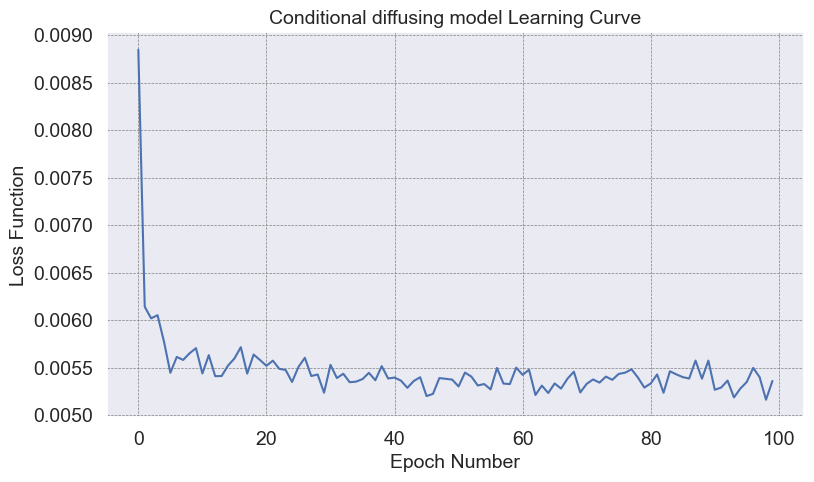

In [37]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 14 (0.5 балла)
По аналогии с прошлым экспериментом с GAN моделью сгенерируйте выборку фейковых объектов равную размеру тестовой выборки и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с GAN моделью?

In [38]:
X_fake_train = generate_with_diffusion(model=diffusionFitter.model, 
                                       y=torch.tensor(y_train, dtype=torch.float, device=DEVICE), latent_dim=latent_dim, 
                                       x=torch.tensor(X_train, dtype=torch.float, device=DEVICE))
X_train = transformer.inverse_transform(X_train)
X_fake_train = transformer.inverse_transform(X_fake_train)

In [39]:
X_fake_test = generate_with_diffusion(model=diffusionFitter.model, 
                                      y=torch.tensor(y_test, dtype=torch.float, device=DEVICE), latent_dim=latent_dim, 
                                      x=torch.tensor(X_test, dtype=torch.float, device=DEVICE))
X_fake_test = transformer.inverse_transform(X_fake_test)
X_test = transformer.inverse_transform(X_test)

In [40]:
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [41]:
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [42]:
auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.7575525900568443


### 1. У меня получилось, что диффузионная модель выдала качество лучше, как я считаю, из-за самой архитектуры сети, так как в диффузии она получилась значительно сложнее (на основе Unet1dModel (https://github.com/huggingface/diffusers/blob/v0.13.0/src/diffusers/models/unet_1d.py#L39) и прошломодульного семинара по UNet).
### 2. Я считаю результаты приемлемыми, так как классификатор на градиентном бустинге стал хуже различать фейковые (сгенеренные моделью) и реальные
### 3. В сравнении с GANом я получил существенный упадок в ROC AUC (с 0.825 (+-0.25)) до ~0.74 (+-0.2). 

## Отзыв

Поздравляю! Вы дошли до конца. Оставьте ваш отзыв ячейкой ниже или отправьте его в канал курса, нам будет очень интересно!

### Интересное дз, заставило больше вникнуть в диффузионные и генеративно-состязателные модели (почитать статьи, почекать исходники моделей с ХФ). Респект 9.9/10 (-0.1 балл за то, что не было какой-то отметки, которую ндо было побить, как в прошломодульном дз)